In [26]:
import numpy as np
from scipy.stats import wasserstein_distance
from preprocess_TCN.acf import *
from preprocess_TCN.gaussianize import *

In [27]:
# From stack overflow - Laplace Fit()

from scipy.stats import laplace
import matplotlib.pyplot as plt
def fit_laplace(arr, axes=0):
    params = laplace.fit(arr, floc=0)
    x = np.linspace(min(arr), max(arr), arr.shape[0])
    print("PARAMS: ", params, x.shape)
    pdf_fitted = laplace.pdf(x, 0, params[1])
    print('Mean pdf_fitter - ', pdf_fitted.mean())
    return pdf_fitted

In [28]:
#### GET SYNTHETIC and REAL DATA
#synthe_X_num = np.load('tab-ddpm/tab-ddpm-main/exp/stock/ddpm_mlp_best/X_num_train.npy')
y_val = np.load('tab-ddpm/tab-ddpm-main/data/stock/y_test.npy')
synthe_y_tabddpm = np.load('tab-ddpm/tab-ddpm-main/exp/stock/ddpm_mlp_best/y_train.npy')
synthe_y_tcn = np.load('quantGan_gen/singleFeature50paths.npy')

In [29]:
y_val.shape
synthe_y_tabddpm.shape
synthe_y_tcn.shape

(50, 127)

In [30]:
y_val[:5]
synthe_y_tabddpm[:5]
synthe_y_tcn[34][:5]


array([-0.5284372 ,  0.38998386, -0.1906271 , -0.90274286, -1.6747433 ],
      dtype=float32)

## Wrong Approach according to Prof. Use mean to create path
### Finding Best path based on wasserstien distance

windows = [1, 5, 20, 100]
wassersteins_list = []

for i in range(len(windows)):
    real_dist = rolling_window(y_val.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(synthe_y_tcn.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0)
    
    wassersteins = []
    for j in range(len(fake_dist.T)):
        wassersteins.append(wasserstein_distance(real_dist, fake_dist[:,j]))
        #print(len(wassersteins))
    wassersteins_list.append(wassersteins)

wassersteins_list = np.array(wassersteins_list)
print(np.sum(wassersteins_list, axis=0).shape)

best_i = np.argmin(np.sum(wassersteins_list, axis=0))
print(f'Best gen Path is y[{best_i}] with EMD = {wassersteins_list[:, best_i]}')


In [31]:
# Draw random returns to generate a path

synthe_y_tcn_draw = []
for i in range(synthe_y_tcn.shape[1]):
    synthe_y_tcn_draw.append(np.random.default_rng().choice(synthe_y_tcn[:,i]))
synthe_y_tcn_draw = np.array(synthe_y_tcn_draw)

In [32]:
synthe_y_tcn_draw.shape
#synthe_y_tabddpm.shape

(127,)

In [33]:
np.random.default_rng().choice(synthe_y_tcn[1])

0.41277385

In [34]:
synthe_y_tcn[1] == 1.2080294

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [35]:
synthe_y_tcn.shape

(50, 127)

In [36]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()

In [37]:
y_val[:5]

array([[ 0.48680769],
       [-0.29801206],
       [-0.73570648],
       [ 0.2090547 ],
       [-0.05805903]])

In [38]:
# Fit y_val for inverse transform
y_val = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(y_val)))
print(y_val.shape)
y_val[:5]

(127, 1)


array([[ 0.84709211],
       [-0.53119988],
       [-1.22567808],
       [ 0.37559532],
       [-0.10503881]])

In [39]:
wasserstein_distance(y_val.reshape(-1), synthe_y_tabddpm)

0.10549620341805926

In [40]:
# Trasform y_val, synthe_y_tabddpm, synthe_y_tcn_best
y_val_trans = (y_val - y_val.mean(axis=0))/y_val.std(axis=0)
y_val_trans = standardScaler2.inverse_transform(y_val_trans)
y_val_trans = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y_val_trans]).squeeze()
y_val_trans = standardScaler1.inverse_transform(y_val_trans.reshape(-1,1))
print(f'checking y: f{y_val_trans.shape}')

synthe_y_tabddpm_trans = (synthe_y_tabddpm - synthe_y_tabddpm.mean(axis=0))/synthe_y_tabddpm.std(axis=0)
synthe_y_tabddpm_trans = standardScaler2.inverse_transform(synthe_y_tabddpm_trans.reshape(-1,1))
synthe_y_tabddpm_trans = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in synthe_y_tabddpm_trans]).squeeze()
synthe_y_tabddpm_trans = standardScaler1.inverse_transform(synthe_y_tabddpm_trans.reshape(-1,1))
print(f'checking synthe_y_tabddpm_trans: f{synthe_y_tabddpm_trans.shape}')

synthe_y_tcn_trans = (synthe_y_tcn_draw - synthe_y_tcn_draw.mean(axis=0))/synthe_y_tcn_draw.std(axis=0)
synthe_y_tcn_trans = standardScaler2.inverse_transform(synthe_y_tcn_trans.reshape(-1,1))
synthe_y_tcn_trans = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in synthe_y_tcn_trans]).squeeze()
synthe_y_tcn_trans = standardScaler1.inverse_transform(synthe_y_tcn_trans.reshape(-1,1))
print(f'checking synthe_y_tcn_trans: f{synthe_y_tcn_trans.shape}')

checking y: f(127, 1)
checking synthe_y_tabddpm_trans: f(127, 1)
checking synthe_y_tcn_trans: f(127, 1)


synthe_y_tcn_trans = (synthe_y_tcn_draw - synthe_y_tcn_draw.mean(axis=0))/synthe_y_tcn_draw.std(axis=0)
synthe_y_tcn_trans = standardScaler2.inverse_transform(synthe_y_tcn_trans.reshape(-1,1))
synthe_y_tcn_trans = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in synthe_y_tcn_trans]).squeeze()
synthe_y_tcn_trans = standardScaler1.inverse_transform(synthe_y_tcn_trans.reshape(-1,1))
print(f'checking synthe_y_tcn_trans: f{synthe_y_tcn_trans.shape}')

In [41]:
#y_val_trans[:5]
#synthe_y_tabddpm_trans[:5]
synthe_y_tcn_trans[:5]

array([[-0.12894483],
       [-0.10964122],
       [ 0.29710895],
       [-0.14049986],
       [-0.49528772]], dtype=float32)

In [42]:
windows = [1, 5, 20, 100]

for i in range(len(windows)):

    real_dist = rolling_window(y_val_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_ddpm = rolling_window(synthe_y_tabddpm_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_tcn = rolling_window(synthe_y_tcn_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    #full_tcn = rolling_window(synthe_y_tcn.T, windows[i], sparse = not (windows[i] == 1)).mean(axis=0).ravel()


    print('For window {}, EMD_fake_DDPM {} vs {} = {:e}'.format(windows[i], fake_dist_ddpm.shape, real_dist.shape, wasserstein_distance(real_dist, fake_dist_ddpm)/real_dist.shape[0]))
    print('For window {}, EMD_fake_QuantGan {} = {:e}'.format(windows[i], fake_dist_tcn.shape, wasserstein_distance(real_dist, fake_dist_tcn)/real_dist.shape[0]))
    #print(f'For window {windows[i]}, EMD_fake_TCN_full = {wasserstein_distance(real_dist, full_tcn)}')
    
    print('------x-------x----------')

For window 1, EMD_fake_DDPM (127,) vs (127,) = 4.403211e-04
For window 1, EMD_fake_QuantGan (127,) = 6.933671e-04
------x-------x----------
For window 5, EMD_fake_DDPM (123,) vs (123,) = 1.818781e-03
For window 5, EMD_fake_QuantGan (123,) = 1.420604e-03
------x-------x----------
For window 20, EMD_fake_DDPM (108,) vs (108,) = 8.936049e-03
For window 20, EMD_fake_QuantGan (108,) = 6.453110e-03
------x-------x----------
For window 100, EMD_fake_DDPM (28,) vs (28,) = 2.054403e-02
For window 100, EMD_fake_QuantGan (28,) = 1.069829e-01
------x-------x----------


## Results and visualizing stylized facts

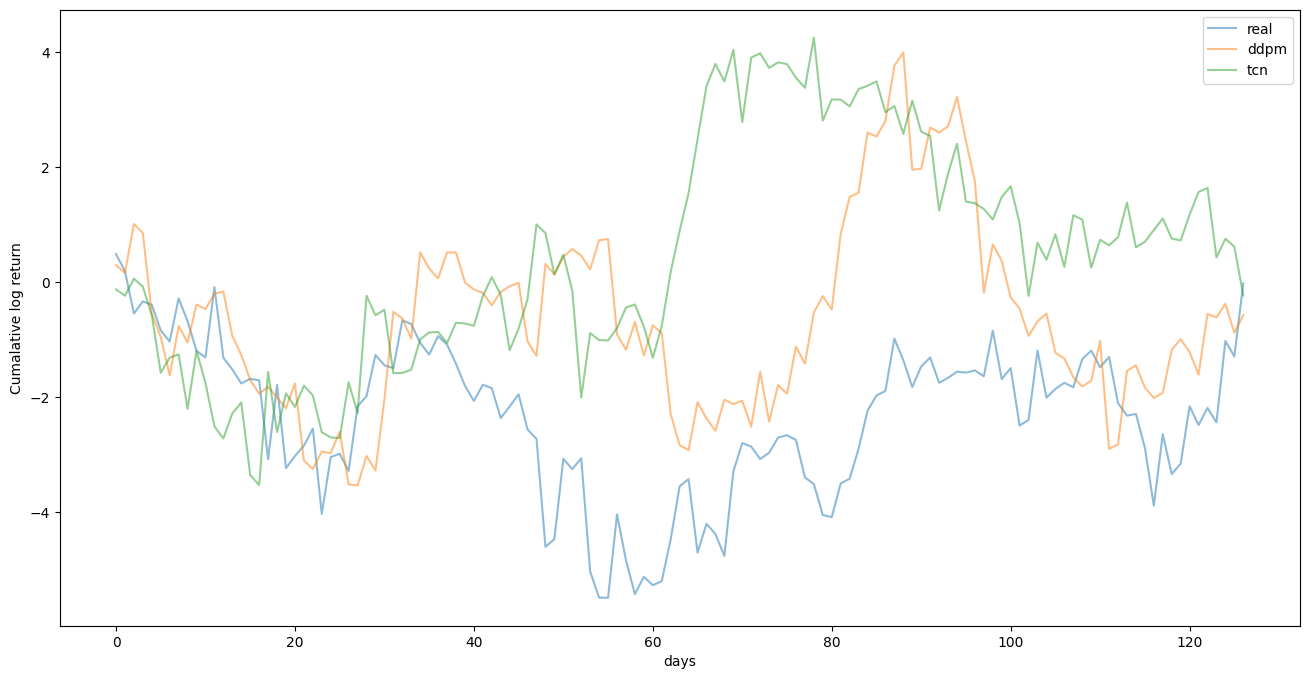

In [43]:
## For 1 feature
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.cumsum(y_val_trans.reshape(-1)).T, alpha=0.5, label='real')
ax.plot(np.cumsum(synthe_y_tabddpm_trans.reshape(-1)).T, alpha=0.5, label='ddpm')
ax.plot(np.cumsum(synthe_y_tcn_trans.reshape(-1)).T, alpha=0.5, label='tcn')
#ax.plot(np.cumsum(y[best_i].reshape(1, -1), axis=1).T, alpha=0.75, label='fake')
#ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()

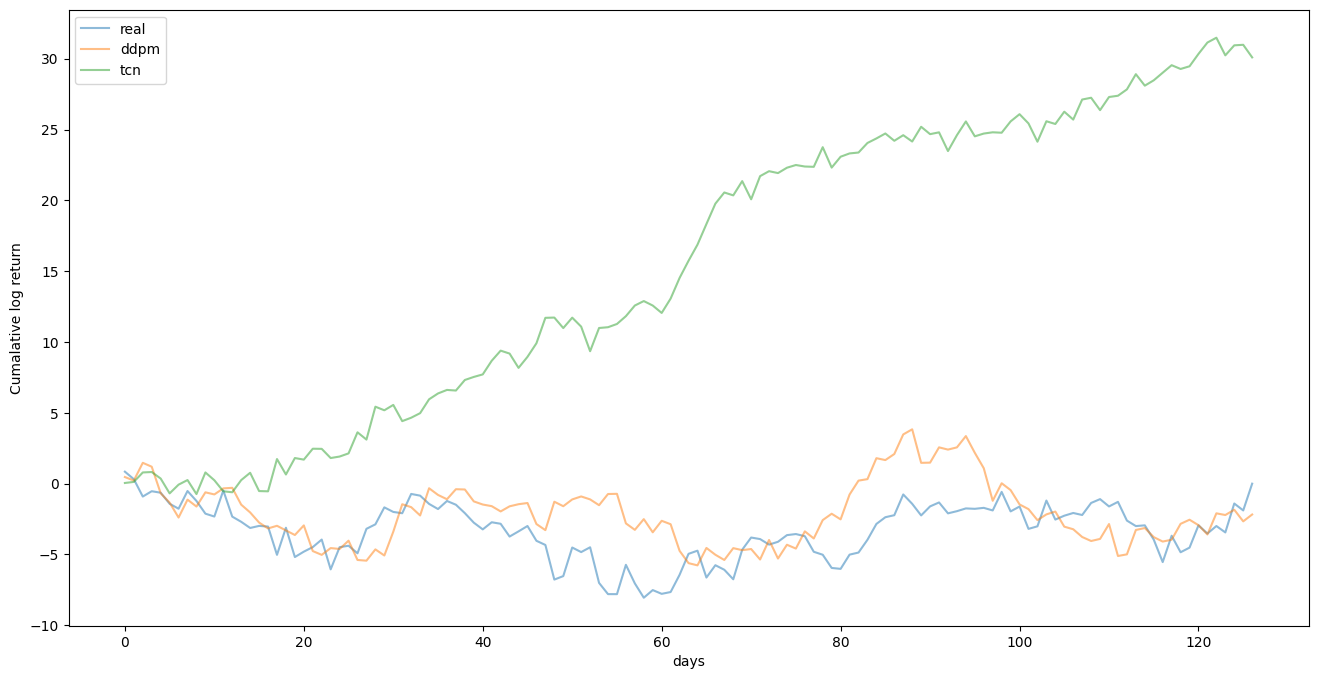

In [44]:
## For 1 feature
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.cumsum(y_val.reshape(-1)).T, alpha=0.5, label='real')
ax.plot(np.cumsum(synthe_y_tabddpm.reshape(-1)).T, alpha=0.5, label='ddpm')
ax.plot(np.cumsum(synthe_y_tcn_draw.reshape(-1)).T, alpha=0.5, label='tcn')
#ax.plot(np.cumsum(synthe_y_tcn[23].reshape(-1)).T, alpha=0.5, label='tcn2')
#ax.plot(np.cumsum(y[best_i].reshape(1, -1), axis=1).T, alpha=0.75, label='fake')
#ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()

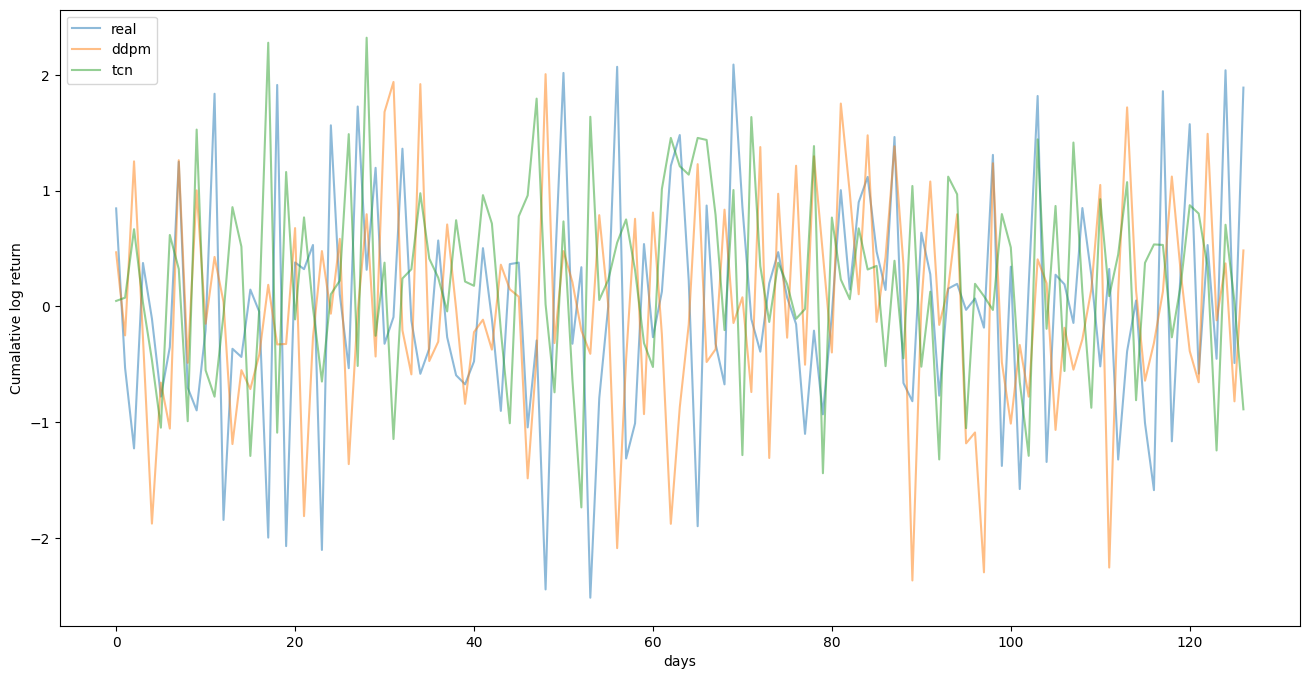

In [45]:
## For 1 feature
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_val.reshape(-1), alpha=0.5, label='real')
ax.plot(synthe_y_tabddpm.reshape(-1), alpha=0.5, label='ddpm')
ax.plot(synthe_y_tcn_draw.reshape(-1), alpha=0.5, label='tcn')
#ax.plot(np.cumsum(y[best_i].reshape(1, -1), axis=1).T, alpha=0.75, label='fake')
#ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()

PARAMS:  (0, 0.48065770507501243) (127,)
Mean pdf_fitter -  0.27933568464602715
PARAMS:  (0, 0.48366180262386554) (127,)
Mean pdf_fitter -  0.26554730348078043
PARAMS:  (0, 0.4951043702894822) (127,)
Mean pdf_fitter -  0.2719738846865452
PARAMS:  (0, 0.8948821919497708) (123,)
Mean pdf_fitter -  0.18492520371997304
PARAMS:  (0, 1.1036104162896665) (123,)
Mean pdf_fitter -  0.14145081953632244
PARAMS:  (0, 1.1564024929951013) (123,)
Mean pdf_fitter -  0.11718200470398553
PARAMS:  (0, 1.601691419940271) (108,)
Mean pdf_fitter -  0.11513078383202194
PARAMS:  (0, 2.4641073106890468) (108,)
Mean pdf_fitter -  0.07467144730738931
PARAMS:  (0, 2.9974930423023007) (108,)
Mean pdf_fitter -  0.0682783736013988


Text(0.5, 0.98, 'QuantGAN_return_train SPY 2016-2019 return distribution')

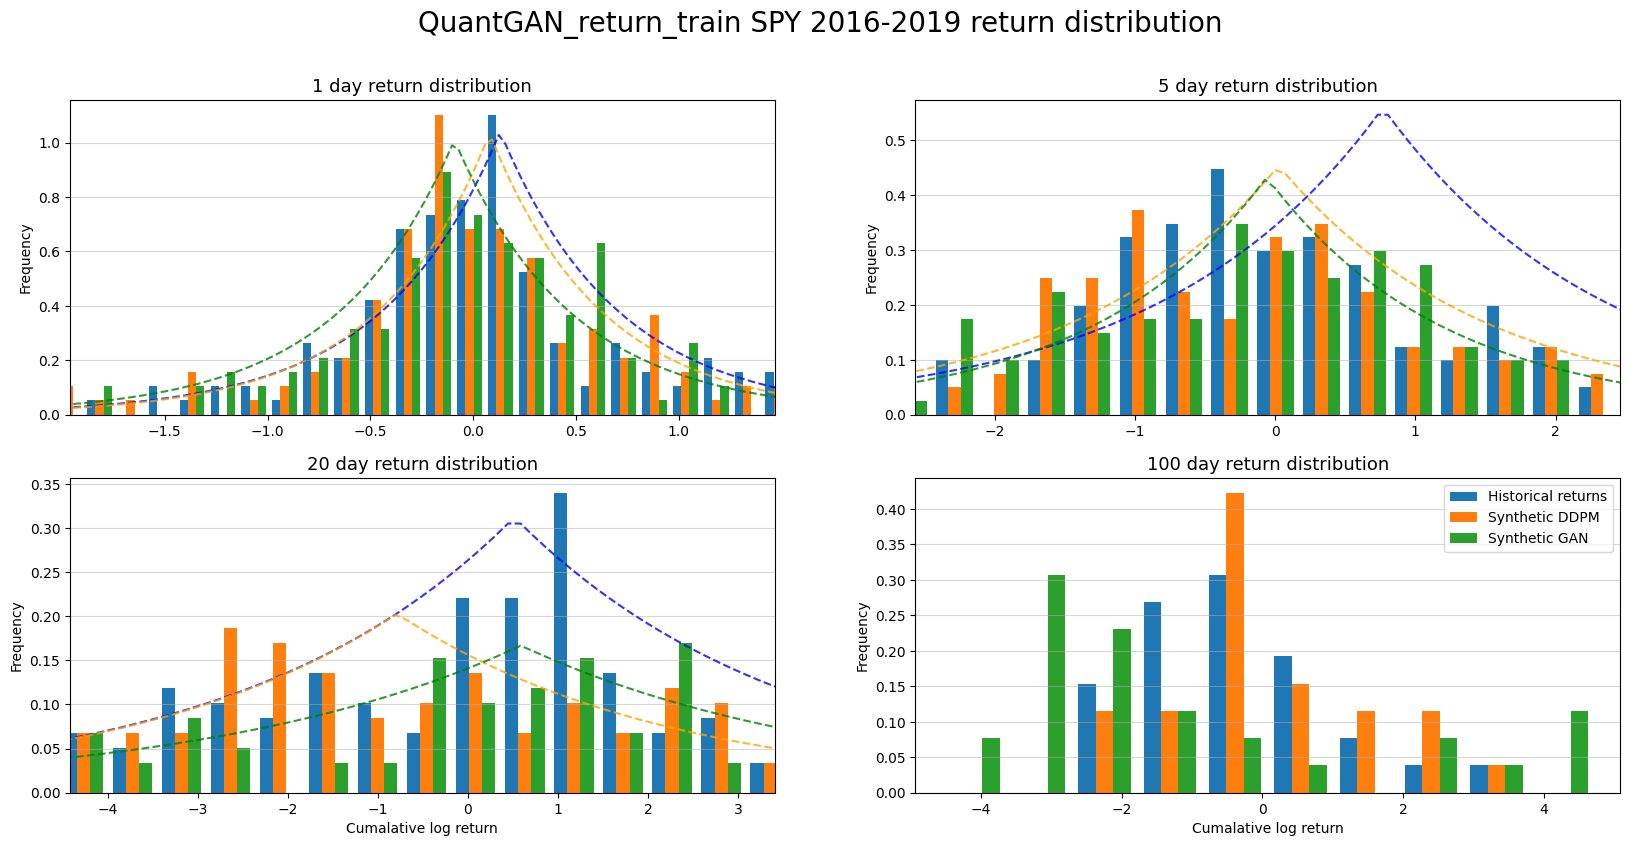

In [21]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))
#print(best_gen_path.shape)

for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    #row = i
    col = i % 2

    real_dist = rolling_window(y_val_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_ddpm = rolling_window(synthe_y_tabddpm_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_tcn = rolling_window(synthe_y_tcn_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    
    if row == 1 and col == 1:
        axs[row, col].hist(np.stack([real_dist, fake_dist_ddpm, fake_dist_tcn], axis=-1), bins=10, density=True)
        #axs[row,col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    else:
        axs[row, col].hist(np.stack([real_dist, fake_dist_ddpm, fake_dist_tcn], axis=-1), bins=25, density=True)
        x_range = np.linspace(*axs[row,col].get_xlim(), num=len(real_dist))
        axs[row,col].plot(x_range, fit_laplace(real_dist).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='blue')
        axs[row,col].plot(x_range, fit_laplace(fake_dist_ddpm).reshape(-1), alpha=0.8, linestyle='dashed', label='ddpm', color='orange')
        axs[row,col].plot(x_range, fit_laplace(fake_dist_tcn).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='green')
        axs[row,col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=13)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    
    if row != 0:
        axs[row,col].set_xlabel('Cumalative log return')
    
    axs[row,col].set_ylabel('Frequency')
    #axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[1,1].legend(['Historical returns', 'Synthetic DDPM', 'Synthetic GAN'])
fig.suptitle('QuantGAN_return_train SPY 2016-2019 return distribution', fontsize=20)

PARAMS:  (0, 0.48065770507501243) (127,)
Mean pdf_fitter -  0.27933568464602715
PARAMS:  (0, 0.48366180262386554) (127,)
Mean pdf_fitter -  0.26554730348078043
PARAMS:  (0, 0.48065770507501243) (127,)
Mean pdf_fitter -  0.27933568464602715
PARAMS:  (0, 0.48797042123738704) (127,)
Mean pdf_fitter -  0.2500323769376483
PARAMS:  (0, 0.8948821919497708) (123,)
Mean pdf_fitter -  0.18492520371997304
PARAMS:  (0, 1.1036104162896665) (123,)
Mean pdf_fitter -  0.14145081953632244
PARAMS:  (0, 0.8948821919497708) (123,)
Mean pdf_fitter -  0.18492520371997304
PARAMS:  (0, 0.8450313270152584) (123,)
Mean pdf_fitter -  0.13573397964644382
PARAMS:  (0, 1.601691419940271) (108,)
Mean pdf_fitter -  0.11513078383202194
PARAMS:  (0, 2.4641073106890468) (108,)
Mean pdf_fitter -  0.07467144730738931
PARAMS:  (0, 1.601691419940271) (108,)
Mean pdf_fitter -  0.11513078383202194
PARAMS:  (0, 1.792701464732764) (108,)
Mean pdf_fitter -  0.09657712285379788
PARAMS:  (0, 1.205031876566267) (28,)
Mean pdf_fitte

Text(0.5, 0.98, 'SPY 2016-2019 return distribution')

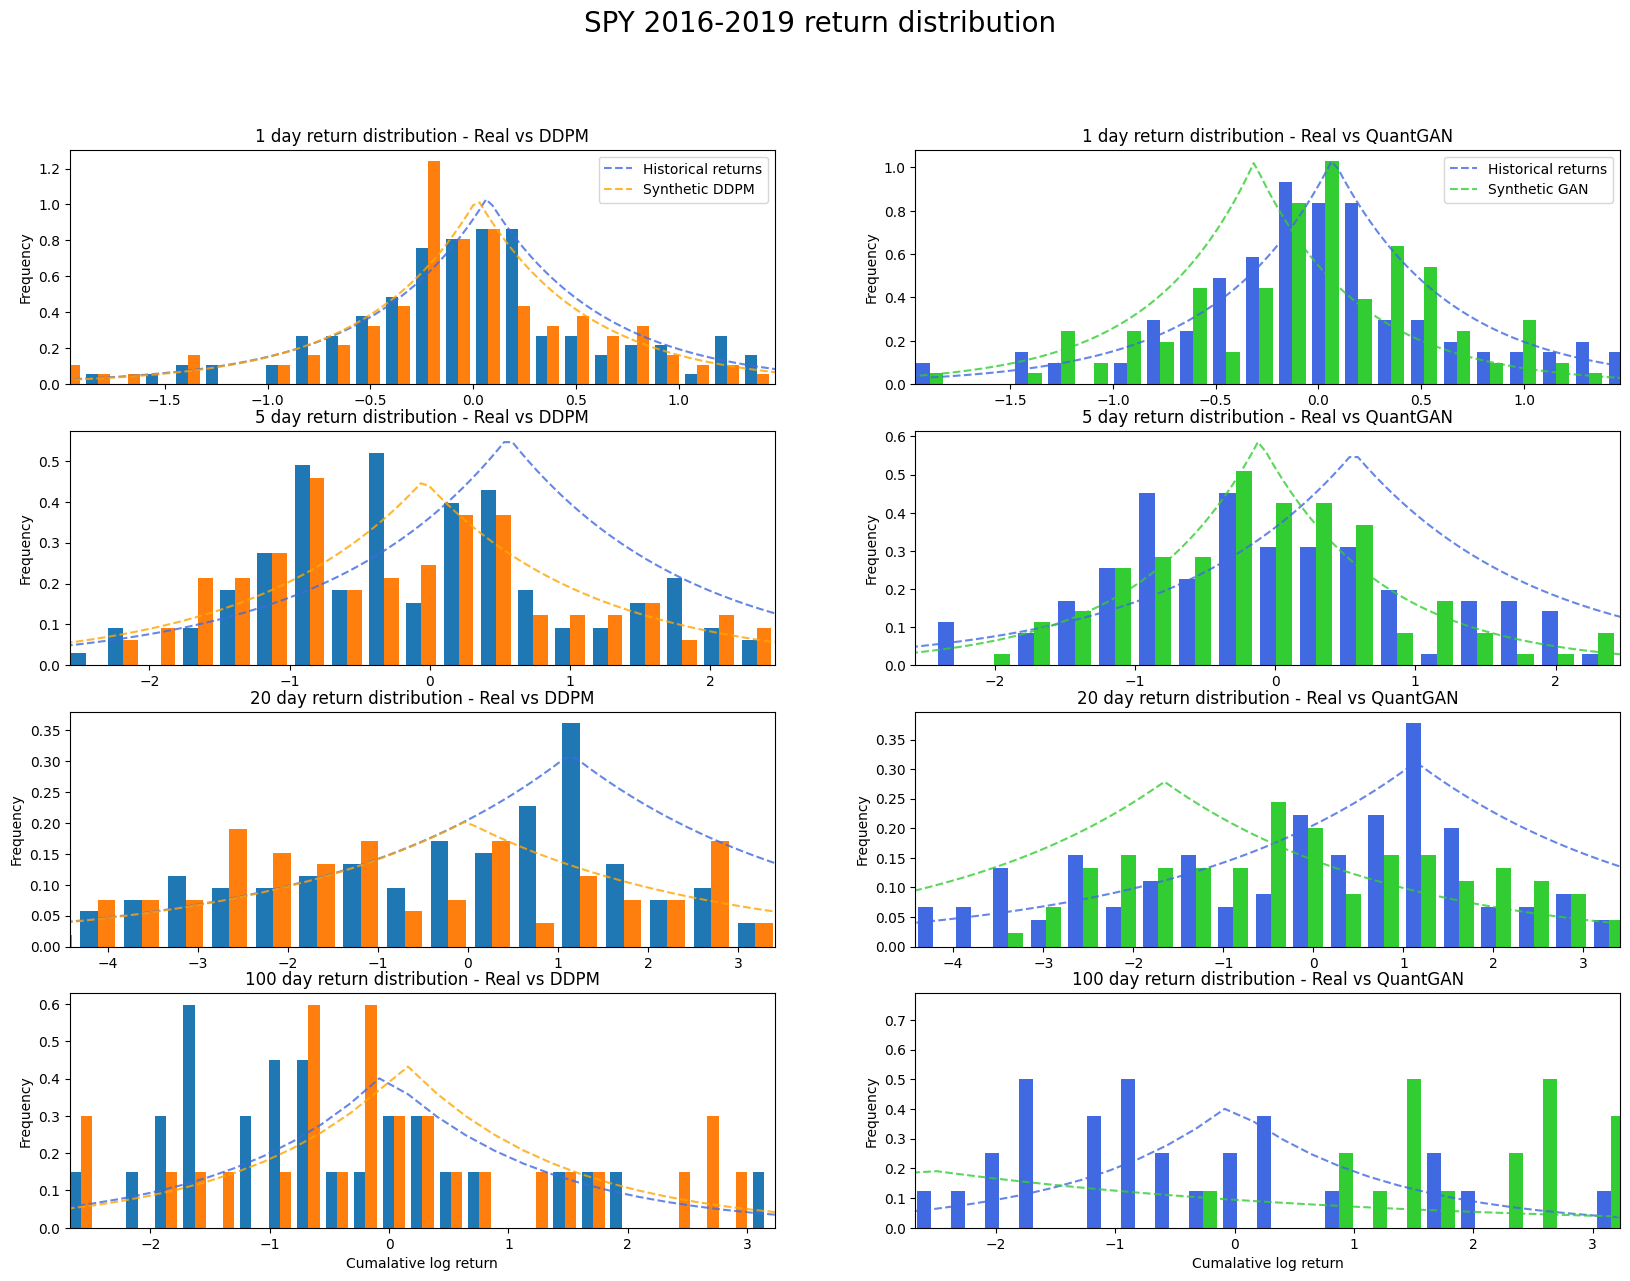

In [71]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 14))
#print(best_gen_path.shape)

for i in range(len(windows)):
    row = i
    #row = i
    #col = i % 2

    real_dist = rolling_window(y_val_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_ddpm = rolling_window(synthe_y_tabddpm_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_tcn = rolling_window(synthe_y_tcn_trans.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    
    #if row == 1 and col == 1:
    #    axs[row, col].hist(np.stack([real_dist, fake_dist_ddpm, fake_dist_tcn], axis=-1), bins=10, density=True)
        #axs[row,col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    #else:
    axs[row, 0].hist(np.stack([real_dist, fake_dist_ddpm], axis=-1), bins=25, density=True)
    x_range = np.linspace(*axs[row,0].get_xlim(), num=len(real_dist))
    axs[row,0].plot(x_range, fit_laplace(real_dist).reshape(-1), alpha=0.8, linestyle='dashed', label='ddpm', color='royalblue')
    axs[row,0].plot(x_range, fit_laplace(fake_dist_ddpm).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='orange')
    axs[row,0].set_xlim(*np.quantile(real_dist, [0.001, .999]))

    axs[3, 0].set_xlabel('Cumalative log return')
    axs[row, 0].set_ylabel('Frequency')
    axs[row, 0].set_title(f'{windows[i]} day return distribution - Real vs DDPM')
    #axs[row,:].set_title('{} day return distribution'.format(windows[i]), size=13)
    #axs[row,:].yaxis.grid(True, alpha=0.5)
    #axs[row,:].yaxis.grid(True, alpha=0.5)
    
    axs[row, 1].hist(np.stack([real_dist, fake_dist_tcn], axis=-1), bins=25, density=True, color=['royalblue', 'limegreen'])
    axs[row, 1].plot(x_range, fit_laplace(real_dist).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='royalblue')
    axs[row, 1].plot(x_range, fit_laplace(fake_dist_tcn).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='limegreen')
    axs[row, 1].set_xlim(*np.quantile(real_dist, [0.001, .999]))

    axs[3, 1].set_xlabel('Cumalative log return')
    axs[row, 1].set_ylabel('Frequency')
    axs[row, 1].set_title(f'{windows[i]} day return distribution - Real vs QuantGAN')

axs[0,0].legend(['Historical returns', 'Synthetic DDPM'])
axs[0,1].legend(['Historical returns', 'Synthetic GAN'])
fig.suptitle('SPY 2016-2019 return distribution', fontsize=20)

Text(0.5, 0.98, 'Autocorrelation of time series dependency')

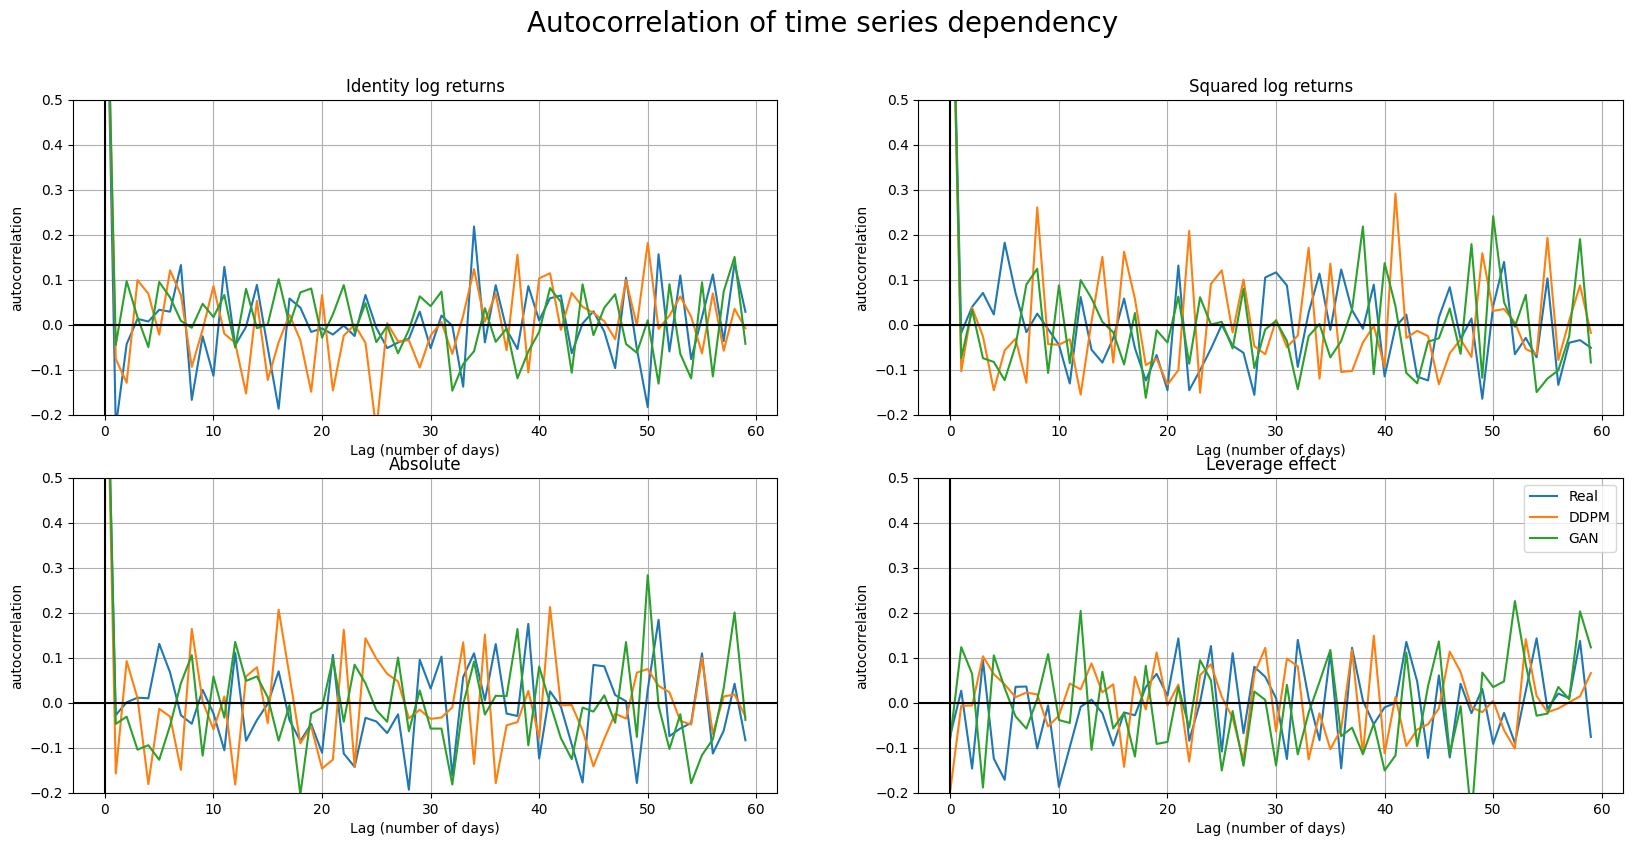

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))

axs[0,0].plot(acf(y_val_trans, 60))
axs[0,0].plot(acf(synthe_y_tabddpm_trans, 60))
axs[0,0].plot(acf(synthe_y_tcn_trans, 60))
axs[0,0].set_ylim(-0.2, 0.5)
axs[0,0].set_title('Identity log returns')

axs[0,1].plot(acf(y_val_trans**2, 60))
axs[0,1].plot(acf(synthe_y_tabddpm_trans**2, 60))
axs[0,1].plot(acf(synthe_y_tcn_trans**2, 60))
axs[0,1].set_ylim(-0.2, 0.5)
axs[0,1].set_title('Squared log returns')

axs[1,0].plot(acf(abs(y_val_trans), 60, le=False))
axs[1,0].plot(acf(abs(synthe_y_tabddpm_trans), 60, le=False))
axs[1,0].plot(acf(abs(synthe_y_tcn_trans), 60, le=False))
axs[1,0].set_ylim(-0.2, 0.5)
axs[1,0].set_title('Absolute')

axs[1,1].plot(acf(y_val_trans, 60, le=True))
axs[1,1].plot(acf(synthe_y_tabddpm_trans, 60, le=True))
axs[1,1].plot(acf(synthe_y_tcn_trans, 60, le=True))
axs[1,1].set_ylim(-0.2, 0.5)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days)', ylabel='autocorrelation')
axs[1,1].legend(['Real', 'DDPM', 'GAN'])
fig.suptitle('Autocorrelation of time series dependency', fontsize=20)

In [23]:
synthe_y_tcn_trans.shape
synthe_y_tabddpm_trans.shape
len(y_val_trans)

127

In [24]:
import math

def acf_score(x, y, k):
    #print(acf(x, k).shape, acf(y, k).shape)
    
    acf_r = (acf(x, k) - acf(y, k))**2 #Retrun ACF
    print('ACF_r = {:e}'.format(math.sqrt(acf_r.mean())))

    acf_abs_r = (acf(abs(x), k) - acf(abs(y), k))**2 #Absolute ACF
    print('ACF_|r| = {:e}'.format(math.sqrt(acf_abs_r.mean())))
    
    acf_sq_r = (acf(x**2, k) - acf(y**2, k))**2 #Sqr ACF
    print('ACF_r^2 = {:e}'.format(math.sqrt(acf_sq_r.mean())))
    
    acf_le = (acf(x, k, le=True) - acf(y, k, le=True))**2 #Leverage Effect
    print('Leverege Effect = {:e}'.format(math.sqrt(acf_le.mean())))
    
    return math.sqrt(acf_r.mean() + acf_abs_r.mean() + acf_sq_r.mean() + acf_le.mean())


print('{:e}'.format(acf_score(y_val_trans.reshape(-1), synthe_y_tabddpm_trans.reshape(-1), 60)))
print('{:e}'.format(acf_score(y_val_trans.reshape(-1), synthe_y_tcn_trans.reshape(-1), 60)))
#print(acf_score(y_val_trans.reshape(-1), y_val_trans.reshape(-1), len(y_val_trans)-1))



ACF_r = 1.056656e-01
ACF_|r| = 1.326045e-01
ACF_r^2 = 1.374898e-01
Leverege Effect = 1.083866e-01
2.437218e-01
ACF_r = 1.105766e-01
ACF_|r| = 1.184948e-01
ACF_r^2 = 1.148853e-01
Leverege Effect = 1.280993e-01
2.363816e-01


In [25]:
stats.kstest(y_val_trans.reshape(-1), synthe_y_tcn_trans.reshape(-1)).pvalue

0.7296145311924568

In [567]:
print('{:%}'.format(stats.kstest(y_val_trans.reshape(-1), synthe_y_tabddpm_trans.reshape(-1)).pvalue))
print('{:%}'.format(stats.kstest(y_val_trans.reshape(-1), synthe_y_tcn_trans.reshape(-1)).pvalue))
print(stats.kstest(y_val_trans.reshape(-1), y_val_trans.reshape(-1)))

96.380698%
82.805256%
KstestResult(statistic=0.0, pvalue=1.0)


In [568]:
y_val_trans.shape

(127, 1)

In [569]:
rolling_window(y_val_trans, 20).std(axis=0).shape

(108, 1)

In [570]:
acf(rolling_window(y_val_trans, 20).std(axis=0), 100)

array([[ 1.        ],
       [ 0.95184431],
       [ 0.91630662],
       [ 0.86402675],
       [ 0.80125509],
       [ 0.73599139],
       [ 0.65756136],
       [ 0.57010707],
       [ 0.48462356],
       [ 0.38753768],
       [ 0.28677049],
       [ 0.19039445],
       [ 0.10804644],
       [ 0.01535887],
       [-0.07166529],
       [-0.15034328],
       [-0.22459484],
       [-0.29659797],
       [-0.35979604],
       [-0.40540678],
       [-0.43937286],
       [-0.43001979],
       [-0.43769191],
       [-0.43248847],
       [-0.41246825],
       [-0.39333827],
       [-0.36151785],
       [-0.31896504],
       [-0.27539168],
       [-0.20695628],
       [-0.15108866],
       [-0.09635464],
       [-0.04866626],
       [ 0.00882756],
       [ 0.06051989],
       [ 0.09431991],
       [ 0.14019617],
       [ 0.17401934],
       [ 0.20729642],
       [ 0.22834445],
       [ 0.24259751],
       [ 0.26109599],
       [ 0.28702896],
       [ 0.29497002],
       [ 0.30720355],
       [ 0

Text(0.5, 1.0, 'Volatility Clustering')

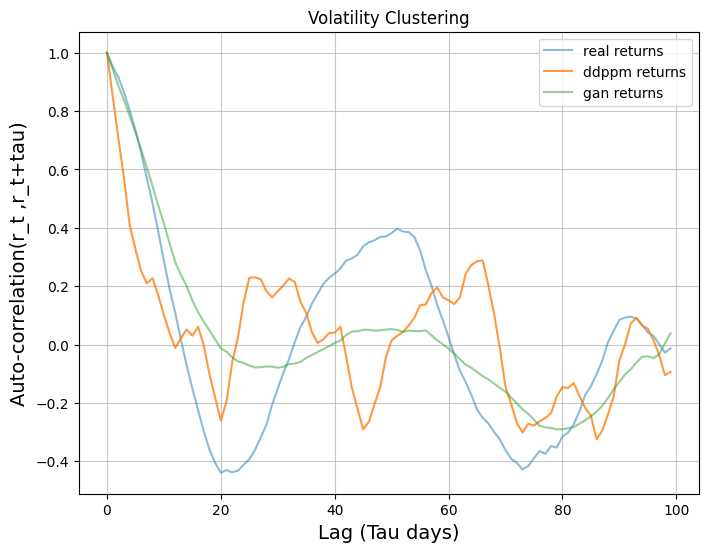

In [571]:
#Volatility Clustering
fig, ax = plt.subplots(figsize=(8, 6))

T = 100
#fake_acf = np.zeros(T)

ax.plot(acf(rolling_window(y_val_trans.reshape(-1), 20).std(axis=0), T, le=False), alpha=0.5)
ax.plot(acf(rolling_window(synthe_y_tabddpm_trans.reshape(-1), 20).std(axis=0), T, le=False), alpha=0.8)
ax.plot(acf(rolling_window(synthe_y_tcn_trans.reshape(-1), 20).std(axis=0), T, le=False), alpha=0.5)

#for i in range(0, len(y), 50):
#    fake_acf = fake_acf + acf(rolling_window(synthe_y_tabddpm_trans[:, i:i+50], 20).std(axis=0), T).mean(axis=1)

#ax.plot(fake_acf/(len(y)//50 + 1))
ax.grid(alpha=0.7)

ax.set_xlabel('Lag (Tau days)', size=14)
ax.set_ylabel('Auto-correlation(r_t ,r_t+tau)', size=14)
ax.legend(['real returns', 'ddppm returns', 'gan returns'])
ax.set_title('Volatility Clustering')

#plt.savefig('vol_clust.png', dpi=300)


Text(0.5, 1.0, 'Volatility Clustering')

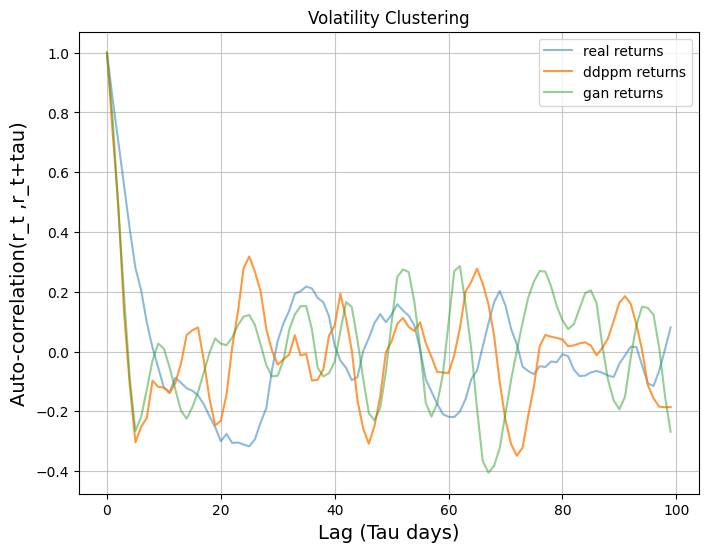

In [60]:
#Volatility Clustering
fig, ax = plt.subplots(figsize=(8, 6))

T = 100
#fake_acf = np.zeros(T)

ax.plot(acf(rolling_window(y_val_trans.reshape(-1), 5).std(axis=0), T, le=False), alpha=0.5)
ax.plot(acf(rolling_window(synthe_y_tabddpm_trans.reshape(-1), 5).std(axis=0), T, le=False), alpha=0.8)
ax.plot(acf(rolling_window(synthe_y_tcn_trans.reshape(-1), 5).std(axis=0), T, le=False), alpha=0.5)

#for i in range(0, len(y), 50):
#    fake_acf = fake_acf + acf(rolling_window(synthe_y_tabddpm_trans[:, i:i+50], 20).std(axis=0), T).mean(axis=1)

#ax.plot(fake_acf/(len(y)//50 + 1))
ax.grid(alpha=0.7)

ax.set_xlabel('Lag (Tau days)', size=14)
ax.set_ylabel('Auto-correlation(r_t ,r_t+tau)', size=14)
ax.legend(['real returns', 'ddppm returns', 'gan returns'])
ax.set_title('Volatility Clustering')


Text(0.5, 1.0, 'Leverage Effect')

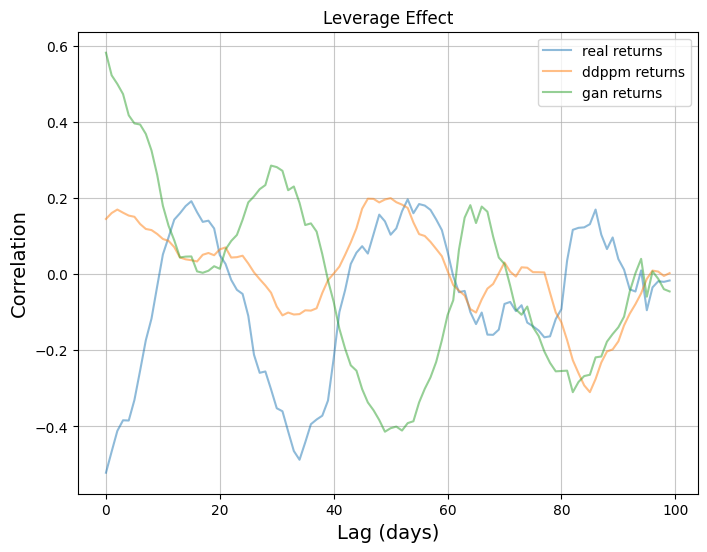

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))

#ax.plot(acf(y_val_trans, 120, le=True), alpha=0.5)
#ax.plot(acf(synthe_y_tabddpm_trans, 120, le=True), alpha=0.5)
#ax.plot(acf(synthe_y_tcn_trans, 120, le=True), alpha=0.5)
ax.plot(acf(rolling_window(y_val_trans.reshape(-1), 20).sum(axis=0), 100, le=True), alpha=0.5)
ax.plot(acf(rolling_window(synthe_y_tabddpm_trans.reshape(-1), 20).sum(axis=0), 100, le=True), alpha=0.5)
ax.plot(acf(rolling_window(synthe_y_tcn_trans.reshape(-1), 20).sum(axis=0), 100, le=True), alpha=0.5)

ax.grid(alpha=0.7)
#ax.set_ylim(-0.3, 0.5)


ax.set_xlabel('Lag (days)', size=14)
ax.set_ylabel('Correlation', size=14)
ax.legend(['real returns', 'ddppm returns', 'gan returns'])
ax.set_title('Leverage Effect')

In [74]:
# Leverage Effect
le_list_real = []
le_list_tabddpm = []
le_list_tcn = []

window = 5

for i in range(len(y_val_trans)-window):
    if i < window:
        continue
    corr = np.corrcoef(y_val_trans.reshape(-1)[:i], rolling_window(y_val_trans.reshape(-1)[:i+window-1], window, sparse=True).std(axis=0))
    #print(corr[0,1])
    if np.isnan(corr[0,1]):
        continue
    else:
        le_list_real.append(corr[0,1])

for i in range(len(synthe_y_tabddpm_trans)-window):
    corr = np.corrcoef(synthe_y_tabddpm_trans.reshape(-1)[:i], rolling_window(synthe_y_tabddpm_trans.reshape(-1)[:i+window-1], window, sparse=True).std(axis=0))
    #print(corr[0,1])
    if np.isnan(corr[0,1]):
        continue
    else:
        le_list_tabddpm.append(corr[0,1])

for i in range(len(synthe_y_tcn_trans)-window):
    corr = np.corrcoef(synthe_y_tcn_trans.reshape(-1)[:i], rolling_window(synthe_y_tcn_trans.reshape(-1)[:i+window-1], window, sparse=True).std(axis=0))
    #print(corr[0,1])
    if np.isnan(corr[0,1]):
        continue
    else:
        le_list_tcn.append(corr[0,1])
        #print(np.array(le_list_tcn).shape, corr[0,1], le_list_tcn)
        

c:\Users\samde\Desktop\Samya\Oregon State Uni\MSProject\DIffSim\tab-ddpm\tab-ddpm-main\ddpm_env\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\samde\Desktop\Samya\Oregon State Uni\MSProject\DIffSim\tab-ddpm\tab-ddpm-main\ddpm_env\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\samde\Desktop\Samya\Oregon State Uni\MSProject\DIffSim\tab-ddpm\tab-ddpm-main\ddpm_env\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\samde\Desktop\Samya\Oregon State Uni\MSProject\DIffSim\tab-ddpm\tab-ddpm-main\ddpm_env\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Users\samde\Desktop\Samya\Oregon State Uni\MSProject\DIffSim\tab-ddpm\tab-ddpm-main\ddpm_env\lib\sit

Text(0.5, 1.0, 'Leverage Effect')

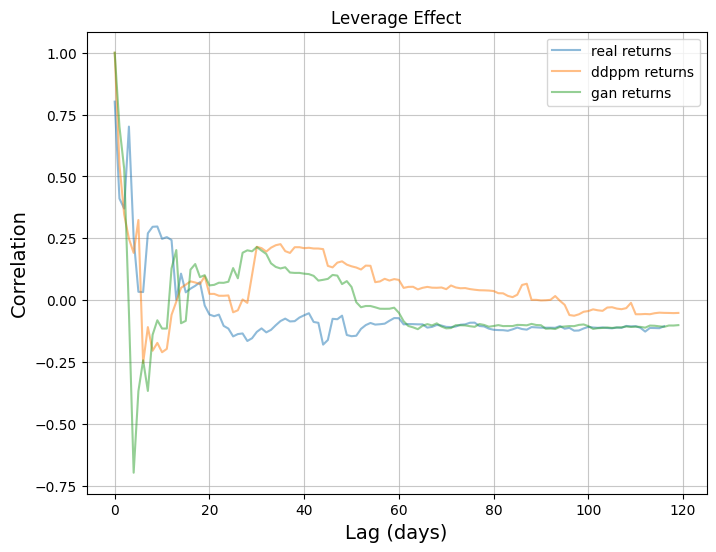

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))

#ax.plot(acf(y_val_trans, 120, le=True), alpha=0.5)
#ax.plot(acf(synthe_y_tabddpm_trans, 120, le=True), alpha=0.5)
ax.plot(range(len(le_list_real)), np.array(le_list_real), alpha=0.5)
ax.plot(range(len(le_list_tabddpm)), np.array(le_list_tabddpm), alpha=0.5)
ax.plot(range(len(le_list_tcn)), np.array(le_list_tcn), alpha=0.5)
#ax.plot(acf(rolling_window(y_test.reshape(-1), 5).std(axis=0), y_test.reshape(-1)[4:]), alpha=0.5)
#ax.plot(acf(rolling_window(y_tabddpm.reshape(-1), 20).mean(axis=0), T, le=True), alpha=0.5)
#ax.plot(acf(rolling_window(synthe_tcn_draw_y.reshape(-1), 20).mean(axis=0), T, le=True), alpha=0.5)

ax.grid(alpha=0.7)
#ax.set_ylim(-0.3, 0.5)


ax.set_xlabel('Lag (days)', size=14)
ax.set_ylabel('Correlation', size=14)
ax.legend(['real returns', 'ddppm returns', 'gan returns'])
ax.set_title('Leverage Effect')

## Eval for nFeatures

In [311]:
y_test = np.load('tab-ddpm/tab-ddpm-main/data/stock-nfeatures/y_test.npy')
X_num_test = np.load('tab-ddpm/tab-ddpm-main/data/stock-nfeatures/X_num_test.npy')
#X_num_tabddpm = np.load('tab-ddpm/tab-ddpm-main/exp/stock-nfeatures/ddpm_mlp_best/X_num_train.npy')
#y_tabddpm = np.load('tab-ddpm/tab-ddpm-main/exp/stock-nfeatures/ddpm_mlp_best/y_train.npy')
X_num_tabddpm = np.load('tab-ddpm/tab-ddpm-main/exp/stock-nfeatures/ddpm_tune_best/X_num_train.npy')
y_tabddpm = np.load('tab-ddpm/tab-ddpm-main/exp/stock-nfeatures/ddpm_tune_best/y_train.npy')
synthe_tcn = np.load('quantGan_gen/allFeature50paths.npy')

In [312]:
y_test.shape
#X_num_test.shape
X_num_tabddpm.shape
y_tabddpm.shape
#synthe_tcn.shape

(127,)

In [313]:
y_test[:5]

array([ 0.00157484,  0.0059374 , -0.00088804,  0.0006768 ,  0.00126811])

In [314]:
y_tabddpm[:5]

array([-0.00281417, -0.00847122, -0.00150668,  0.00146606, -0.00230329])

In [315]:
synthe_tcn[0][-1][:5]

array([-0.10187107, -0.38037577,  1.2278552 ,  0.13373317,  1.1286689 ],
      dtype=float32)

In [316]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()

In [317]:
y_test[:5]

array([ 0.00157484,  0.0059374 , -0.00088804,  0.0006768 ,  0.00126811])

In [318]:
y_tabddpm[:5]

array([-0.00281417, -0.00847122, -0.00150668,  0.00146606, -0.00230329])

In [319]:
synthe_tcn[3][-1][:5]

array([-1.0799681 , -0.5529846 , -0.41024476,  0.46626052,  0.29636744],
      dtype=float32)

In [320]:
synthe_tcn[:,1,121].shape

(50,)

In [321]:
# Draw random returns to generate a path

synthe_tcn_draw = []
for i in range(synthe_tcn.shape[1]):
    tcn_draw_feature = []
    for j in range(synthe_tcn.shape[2]):
        tcn_draw_feature.append(np.random.default_rng().choice(synthe_tcn[:,i,j]))
    synthe_tcn_draw.append(tcn_draw_feature)
synthe_tcn_draw = np.array(synthe_tcn_draw).T


In [322]:
synthe_tcn_draw.shape
#X_num_test.shape

(127, 6)

In [323]:
#Gaussianize
y_tabddpm = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(y_tabddpm.reshape(-1,1))))
synthe_tcn_draw_y = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(synthe_tcn_draw[:,-1].reshape(-1,1))))
y_test = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(y_test.reshape(-1,1))))

In [324]:
synthe_tcn_draw[:,-1].shape

(127,)

In [325]:
# Trasform y_val, synthe_y_tabddpm, synthe_y_tcn_best
#y_test = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(y_test.reshape(-1,1))))
y_test = (y_test - y_test.mean(axis=0))/y_test.std(axis=0)
y_test = standardScaler2.inverse_transform(y_test)
y_test = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y_test]).squeeze()
y_test = standardScaler1.inverse_transform(y_test.reshape(-1,1))
print(f'checking y: f{y_test.shape}')

#y_tabddpm = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(y_tabddpm.reshape(-1,1))))
y_tabddpm = (y_tabddpm - y_tabddpm.mean(axis=0))/y_tabddpm.std(axis=0)
y_tabddpm = standardScaler2.inverse_transform(y_tabddpm.reshape(-1,1))
y_tabddpm = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y_tabddpm]).squeeze()
y_tabddpm = standardScaler1.inverse_transform(y_tabddpm.reshape(-1,1))
print(f'checking synthe_y_tabddpm_trans: f{y_tabddpm.shape}')

#synthe_tcn_draw_y = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(synthe_tcn_draw[:,-1].reshape(-1,1))))
synthe_tcn_draw_y = (synthe_tcn_draw_y - synthe_tcn_draw_y.mean(axis=0))/synthe_tcn_draw_y.std(axis=0)
synthe_tcn_draw_y = standardScaler2.inverse_transform(synthe_tcn_draw_y.reshape(-1,1))
synthe_tcn_draw_y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in synthe_tcn_draw_y]).squeeze()
synthe_tcn_draw_y = standardScaler1.inverse_transform(synthe_tcn_draw_y.reshape(-1,1))
print(f'checking synthe_y_tabddpm_trans: f{synthe_tcn_draw_y.shape}')

checking y: f(127, 1)
checking synthe_y_tabddpm_trans: f(127, 1)
checking synthe_y_tabddpm_trans: f(127, 1)


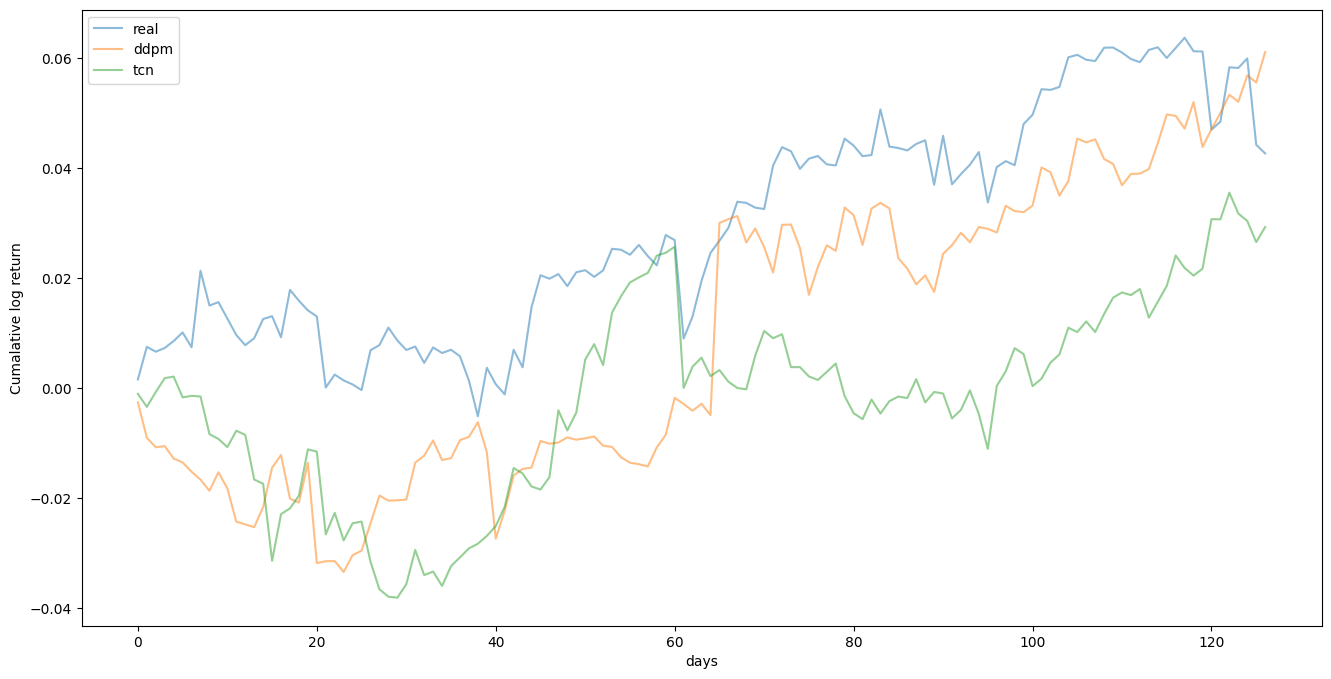

In [338]:
## Trained of N features feature
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.cumsum(y_test.reshape(-1)).T, alpha=0.5, label='real')
ax.plot(np.cumsum(y_tabddpm.reshape(-1)).T, alpha=0.5, label='ddpm')
ax.plot(np.cumsum(synthe_tcn_draw_y.reshape(-1)).T, alpha=0.5, label='tcn')
#ax.plot(np.cumsum(y[best_i].reshape(1, -1), axis=1).T, alpha=0.75, label='fake')
#ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return')
ax.legend()


In [339]:
#KS Test
print('{:%}'.format(stats.kstest(y_test.reshape(-1), y_tabddpm.reshape(-1)).pvalue))
print('{:%}'.format(stats.kstest(y_test.reshape(-1), synthe_tcn_draw_y.reshape(-1)).pvalue))

82.805256%
52.053748%


In [328]:
fit_laplace(y_tabddpm.reshape(-1))

PARAMS:  (0, 0.003265466118437123) (127,)
Mean pdf_fitter -  18.625567549137198


array([5.77195861e-01, 6.56837395e-01, 7.47467875e-01, 8.50603557e-01,
       9.67969909e-01, 1.10153048e+00, 1.25351975e+00, 1.42648051e+00,
       1.62330642e+00, 1.84729037e+00, 2.10217966e+00, 2.39223859e+00,
       2.72231988e+00, 3.09794581e+00, 3.52540063e+00, 4.01183572e+00,
       4.56538915e+00, 5.19532194e+00, 5.91217291e+00, 6.72793503e+00,
       7.65625608e+00, 8.71266696e+00, 9.91484149e+00, 1.12828922e+01,
       1.28397066e+01, 1.46113304e+01, 1.66274030e+01, 1.89216535e+01,
       2.15324649e+01, 2.45035163e+01, 2.78845136e+01, 3.17320211e+01,
       3.61104081e+01, 4.10929254e+01, 4.67629307e+01, 5.32152839e+01,
       6.05579334e+01, 6.89137222e+01, 7.84224435e+01, 8.92431790e+01,
       1.01556961e+02, 1.15569799e+02, 1.31516129e+02, 1.49662736e+02,
       1.37657951e+02, 1.20966925e+02, 1.06299685e+02, 9.34108481e+01,
       8.20847827e+01, 7.21320028e+01, 6.33859974e+01, 5.57004452e+01,
       4.89467662e+01, 4.30119708e+01, 3.77967693e+01, 3.32139110e+01,
      

PARAMS:  (0, 0.003265466118437123) (127, 1)
Mean pdf_fitter -  18.625567549137198
PARAMS:  (0, 0.0033142932756679263) (127, 1)
Mean pdf_fitter -  25.887791561794273


Text(0, 0.5, 'Frequency')

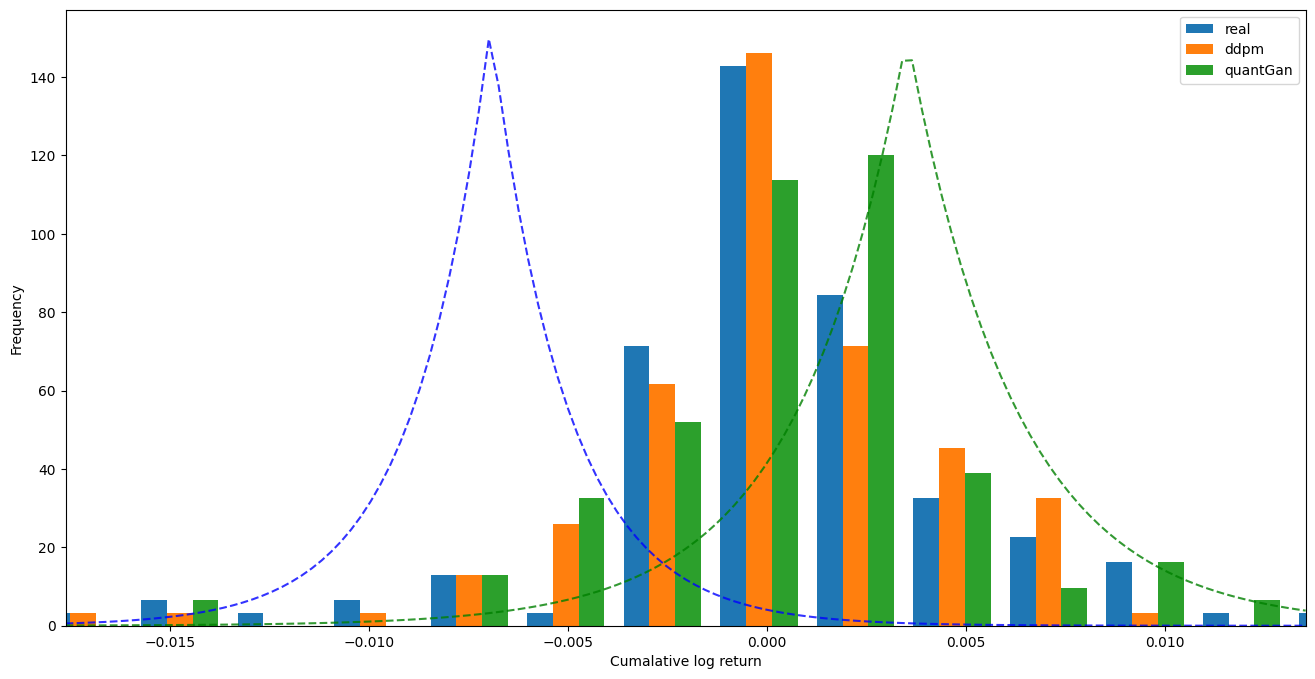

In [329]:
## Trained of N features feature
fig, ax = plt.subplots(figsize=(16,8))
#ax.plot(fit_laplace(y_test).reshape(-1).T, alpha=0.5, label='real')


ax.hist(np.stack([y_test.reshape(-1), y_tabddpm.reshape(-1), synthe_tcn_draw_y.reshape(-1)], axis=-1), bins=25, density=True)
ax.set_xlim(*np.quantile(y_test, [0.001, .999]))
ax.legend(['real', 'ddpm', 'quantGan'])

x_range = np.linspace(*ax.get_xlim(), num=127)


ax.plot(x_range, fit_laplace(y_tabddpm).reshape(-1), alpha=0.8, linestyle='dashed', label='ddpm', color='blue')
ax.plot(x_range, fit_laplace(synthe_tcn_draw_y).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='green')
#ax.plot(synthe_tcn[13][-1].reshape(-1), alpha=0.5, label='tcn')
#ax.plot(np.cumsum(y[best_i].reshape(1, -1), axis=1).T, alpha=0.75, label='fake')
#ax.set_title('Generated log return path vs Real log return paths'.format(len(y)))
ax.set_xlabel('Cumalative log return')
ax.set_ylabel('Frequency')



In [330]:
_ = rolling_window(y_test.reshape(-1), 5).sum(axis=0).ravel()
np.quantile(_, [0.001, 0.01, 0.1, 0.9, 0.999])

array([-0.01682892, -0.01519805, -0.00693292,  0.01198374,  0.02100417])

PARAMS:  (0, 0.0062532983499093715) (123,)
Mean pdf_fitter -  24.78797852518902
PARAMS:  (0, 0.008061446383378008) (123,)
Mean pdf_fitter -  17.215960072434427
PARAMS:  (0, 0.007921002166582864) (123,)
Mean pdf_fitter -  20.170847066946266
PARAMS:  (0, 0.008529744454735705) (118,)
Mean pdf_fitter -  18.32849849827679
PARAMS:  (0, 0.010288055196609145) (118,)
Mean pdf_fitter -  14.388327401159431
PARAMS:  (0, 0.01229009648601678) (118,)
Mean pdf_fitter -  13.740415506895179
PARAMS:  (0, 0.012706843888311744) (108,)
Mean pdf_fitter -  15.913932283589249
PARAMS:  (0, 0.015889579365617613) (108,)
Mean pdf_fitter -  12.440904450992512
PARAMS:  (0, 0.018604053241031378) (108,)
Mean pdf_fitter -  10.127913982516175


C:\Users\samde\AppData\Local\Temp\ipykernel_15044\2274166716.py:26: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  axs[row, col].set_xlim(*np.quantile(real_dist, [0.01, 0.33, 0.66, 0.999]))


Text(0.5, 0.98, 'QuantGAN_return_train SPY 2016-2019 return distribution')

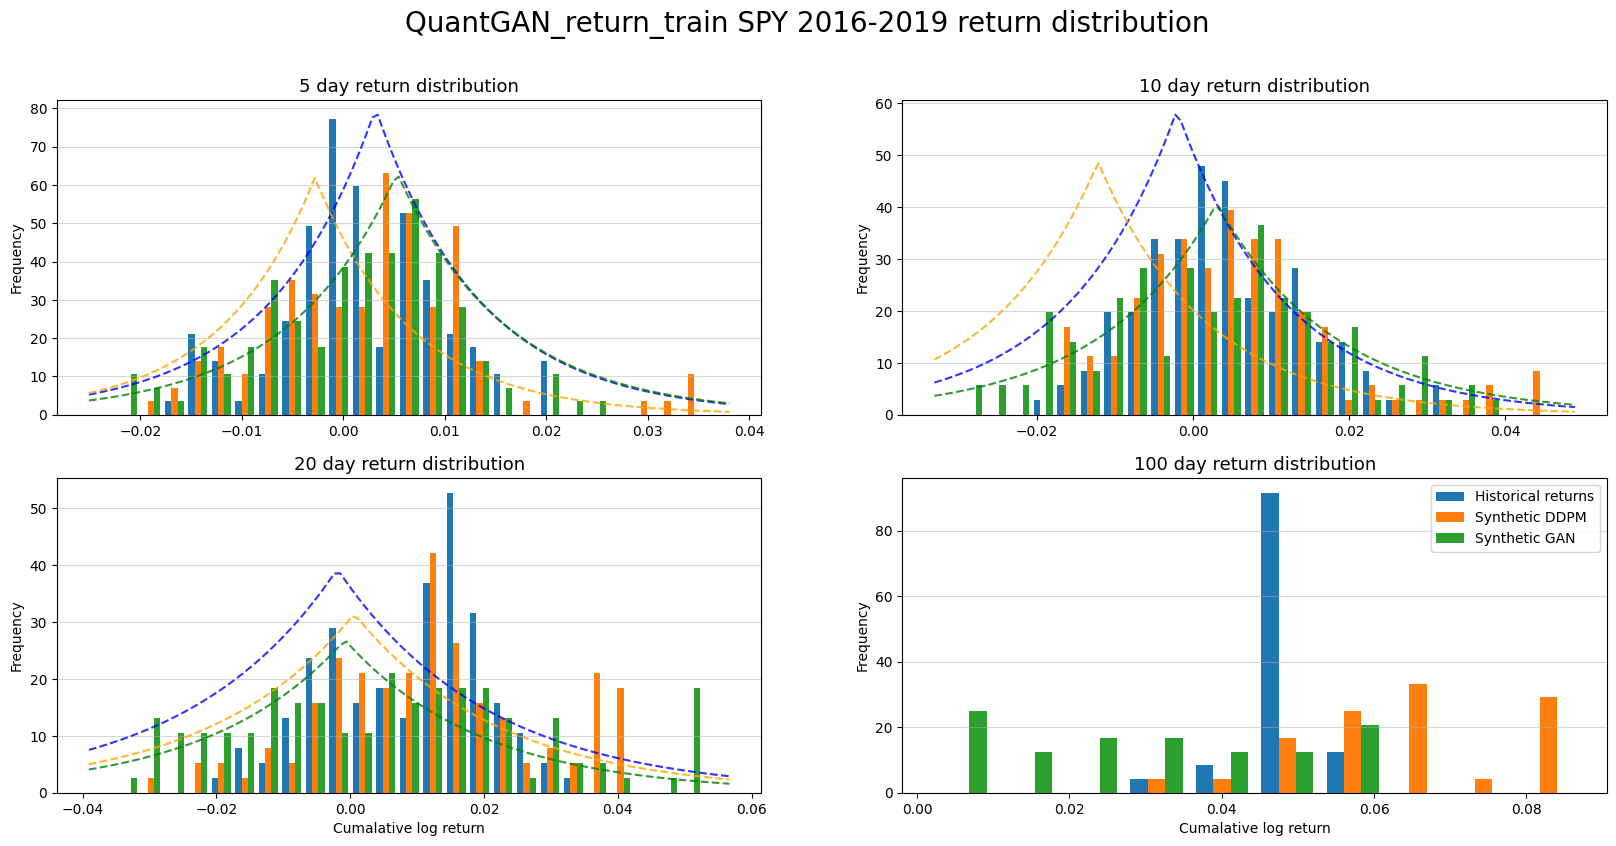

In [337]:
n_bins = 50
windows = [5, 10, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))
#print(best_gen_path.shape)

for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    #row = i
    col = i % 2

    real_dist = rolling_window(y_test.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_ddpm = rolling_window(y_tabddpm.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_tcn = rolling_window(synthe_tcn_draw_y.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    
    #print('YO', fit_laplace(real_dist).reshape(-1).mean())
    #print('YO', fit_laplace(y_tabddpm).reshape(-1).mean())
    #print('YO', fit_laplace(synthe_tcn_draw_y).reshape(-1).mean())

    if row == 1 and col == 1:
        axs[row, col].hist(np.stack([real_dist, fake_dist_ddpm, fake_dist_tcn], axis=-1), bins=10, density=True)
        #axs[row,col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    else:
        axs[row, col].hist(np.stack([real_dist, fake_dist_ddpm, fake_dist_tcn], axis=-1), bins=25, density=True)
        x_range = np.linspace(*axs[row,col].get_xlim(), num=len(real_dist))
        axs[row, col].set_xlim(*np.quantile(real_dist, [0.01, 0.33, 0.66, 0.999]))
        axs[row, col].plot(x_range, fit_laplace(real_dist).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='blue')
        axs[row, col].plot(x_range, fit_laplace(fake_dist_ddpm).reshape(-1), alpha=0.8, linestyle='dashed', label='ddpm', color='orange')
        axs[row, col].plot(x_range, fit_laplace(fake_dist_tcn).reshape(-1), alpha=0.8, linestyle='dashed', label='real', color='green')
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=13)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    
    if row != 0:
        axs[row,col].set_xlabel('Cumalative log return')
    
    axs[row,col].set_ylabel('Frequency')
    #axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[1,1].legend(['Historical returns', 'Synthetic DDPM', 'Synthetic GAN'])
fig.suptitle('QuantGAN_return_train SPY 2016-2019 return distribution', fontsize=20)

In [334]:
# Wasserstein Distance
windows = [1, 5, 20, 100]

for i in range(len(windows)):

    real_dist = rolling_window(y_test.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_ddpm = rolling_window(y_tabddpm.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist_tcn = rolling_window(synthe_tcn_draw_y.reshape(-1), windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    #full_tcn = rolling_window(synthe_y_tcn.T, windows[i], sparse = not (windows[i] == 1)).mean(axis=0).ravel()


    print('For window {}, EMD_fake_DDPM {} vs {} = {:e}'.format(windows[i], fake_dist_ddpm.shape, real_dist.shape, wasserstein_distance(real_dist, fake_dist_ddpm)/real_dist.shape[0]))
    print('For window {}, EMD_fake_QuantGan {} = {:e}'.format(windows[i], fake_dist_tcn.shape, wasserstein_distance(real_dist, fake_dist_tcn)/real_dist.shape[0]))
    #print(f'For window {windows[i]}, EMD_fake_TCN_full = {wasserstein_distance(real_dist, full_tcn)}')
    
    print('------x-------x----------')

For window 1, EMD_fake_DDPM (127,) vs (127,) = 5.106787e-06
For window 1, EMD_fake_QuantGan (127,) = 5.904130e-06
------x-------x----------
For window 5, EMD_fake_DDPM (123,) vs (123,) = 1.559988e-05
For window 5, EMD_fake_QuantGan (123,) = 1.400402e-05
------x-------x----------
For window 20, EMD_fake_DDPM (108,) vs (108,) = 3.617040e-05
For window 20, EMD_fake_QuantGan (108,) = 8.636183e-05
------x-------x----------
For window 100, EMD_fake_DDPM (28,) vs (28,) = 5.630576e-04
For window 100, EMD_fake_QuantGan (28,) = 6.638992e-04
------x-------x----------


In [343]:
#ACF Score
import math

def acf_score(x, y, k):
    #print(acf(x, k).shape, acf(y, k).shape)
    
    acf_r = (acf(x, k) - acf(y, k))**2 #Retrun ACF
    print('ACF_r = {:e}'.format(math.sqrt(acf_r.mean())))

    acf_abs_r = (acf(abs(x), k) - acf(abs(y), k))**2 #Absolute ACF
    print('ACF_|r| = {:e}'.format(math.sqrt(acf_abs_r.mean())))
    
    acf_sq_r = (acf(x**2, k) - acf(y**2, k))**2 #Sqr ACF
    print('ACF_r^2 = {:e}'.format(math.sqrt(acf_sq_r.mean())))
    
    acf_le = (acf(x, k, le=True) - acf(y, k, le=True))**2 #Leverage Effect
    print('Leverege Effect = {:e}'.format(math.sqrt(acf_le.mean())))
    
    return math.sqrt(acf_r.mean() + acf_abs_r.mean() + acf_sq_r.mean() + acf_le.mean())


print('{:e}'.format(acf_score(y_test.reshape(-1), y_tabddpm.reshape(-1), 126)))
print('{:e}'.format(acf_score(y_test.reshape(-1), synthe_tcn_draw_y.reshape(-1), 126)))
#print(acf_score(y_test.reshape(-1), y_test.reshape(-1), len(y_test)-1))


ACF_r = 1.028182e-01
ACF_|r| = 1.103400e-01
ACF_r^2 = 7.982600e-02
Leverege Effect = 1.275619e-01
2.130510e-01
ACF_r = 1.219926e-01
ACF_|r| = 1.058974e-01
ACF_r^2 = 8.543895e-02
Leverege Effect = 1.239125e-01
2.207953e-01


Text(0.5, 1.0, 'All Features trained - Volatility Clustering')

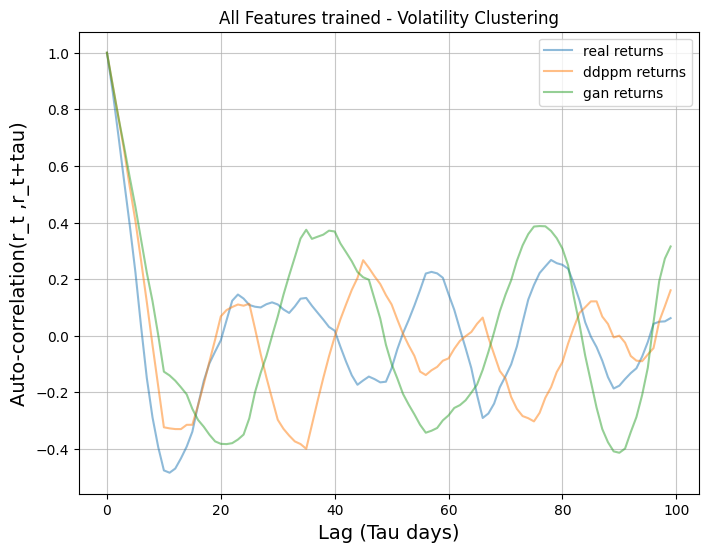

In [368]:
#Volatility Clustering
fig, ax = plt.subplots(figsize=(8, 6))

T = 100
#fake_acf = np.zeros(T)

ax.plot(acf(rolling_window(y_test.reshape(-1), 10).std(axis=0), T, le=False), alpha=0.5)
ax.plot(acf(rolling_window(y_tabddpm.reshape(-1), 10).std(axis=0), T, le=False), alpha=0.5)
ax.plot(acf(rolling_window(synthe_tcn_draw_y.reshape(-1), 10).std(axis=0), T, le=False), alpha=0.5)

#for i in range(0, len(y), 50):
#    fake_acf = fake_acf + acf(rolling_window(synthe_y_tabddpm_trans[:, i:i+50], 20).std(axis=0), T).mean(axis=1)

#ax.plot(fake_acf/(len(y)//50 + 1))
ax.grid(alpha=0.7)

ax.set_xlabel('Lag (Tau days)', size=14)
ax.set_ylabel('Auto-correlation(r_t ,r_t+tau)', size=14)
ax.legend(['real returns', 'ddppm returns', 'gan returns'])
ax.set_title('All Features trained - Volatility Clustering')

In [496]:
np.corrcoef(y_test.reshape(-1)[:35], rolling_window(y_test.reshape(-1)[:35+5-1], 5, sparse=True).std(axis=0))

array([[1.        , 0.21331638],
       [0.21331638, 1.        ]])

In [526]:
np.corrcoef(synthe_tcn_draw_y.reshape(-1)[:35], rolling_window(synthe_tcn_draw_y.reshape(-1)[:35+5-1], 5, sparse=True).std(axis=0))[0]

array([ 1.        , -0.14737987])

In [605]:
le_list_real = []
le_list_tabddpm = []
le_list_tcn = []

window = 20

for i in range(len(y_test)-window):
    if i < window:
        continue
    corr = np.corrcoef(y_test.reshape(-1)[:i], rolling_window(y_test.reshape(-1)[:i+window-1], window, sparse=True).std(axis=0))
    #print(corr[0,1])
    
    if np.isnan(corr[0,1]):
        continue
    else:
        le_list_real.append(corr[0,1])
    
    #le_list_real.append(corr[0,1])

for i in range(len(y_tabddpm)-window):
    if i < window:
        continue
    corr = np.corrcoef(y_tabddpm.reshape(-1)[:i], rolling_window(y_tabddpm.reshape(-1)[:i+window-1], window, sparse=True).std(axis=0))
    #print(corr[0,1])
    
    if np.isnan(corr[0,1]):
        continue
    else:
        le_list_tabddpm.append(corr[0,1])
    
    #le_list_tabddpm.append(corr[0,1])

for i in range(len(synthe_tcn_draw_y)-window):
    if i < window:
        continue
    corr = np.corrcoef(synthe_tcn_draw_y.reshape(-1)[:i], rolling_window(synthe_tcn_draw_y.reshape(-1)[:i+window-1], window, sparse=True).std(axis=0))
    #print(corr[0,1])
    
    if np.isnan(corr[0,1]):
        continue
    else:
        le_list_tcn.append(corr[0,1])
        #print(np.array(le_list_tcn).shape, corr[0,1], le_list_tcn)
    
    #le_list_tcn.append(corr[0,1])
        

print(np.array(le_list_real).shape)
print(np.array(le_list_tabddpm).shape)
print(np.array(le_list_tcn).shape)

(87,)
(87,)
(87,)


In [606]:
le_list_tabddpm[:5]
le_list_real[:5]

[0.31637478450288026,
 0.317827931823027,
 0.2752210382472759,
 0.21158444196710877,
 0.21658333676907587]

In [607]:
np.array(le_list_tabddpm).shape
len(le_list_tabddpm)
np.array(le_list_tcn).shape
#synthe_tcn_draw_y.shape

(87,)

Text(0.5, 1.0, 'All Features Trained Leverage Effect')

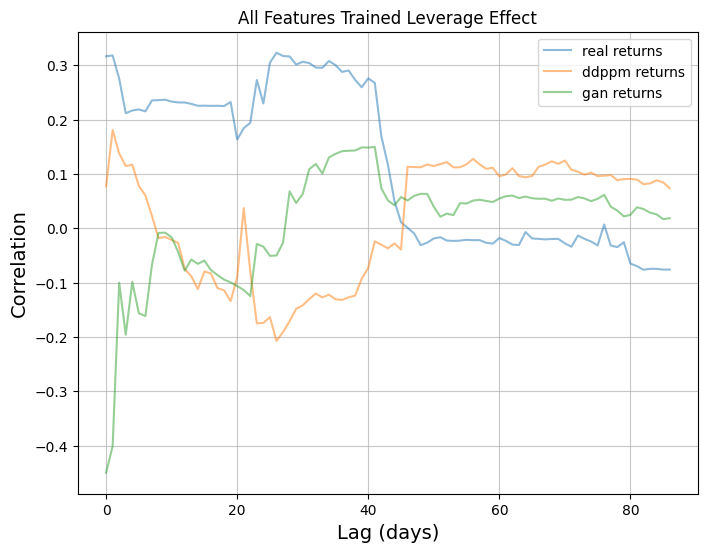

In [608]:
fig, ax = plt.subplots(figsize=(8, 6))

#ax.plot(acf(y_val_trans, 120, le=True), alpha=0.5)
#ax.plot(acf(synthe_y_tabddpm_trans, 120, le=True), alpha=0.5)
ax.plot(range(len(le_list_real)), np.array(le_list_real), alpha=0.5)
ax.plot(range(len(le_list_tabddpm)), np.array(le_list_tabddpm), alpha=0.5)
ax.plot(range(len(le_list_tcn)), np.array(le_list_tcn), alpha=0.5)
#ax.plot(acf(rolling_window(y_test.reshape(-1), 5).std(axis=0), y_test.reshape(-1)[4:]), alpha=0.5)
#ax.plot(acf(rolling_window(y_tabddpm.reshape(-1), 20).mean(axis=0), T, le=True), alpha=0.5)
#ax.plot(acf(rolling_window(synthe_tcn_draw_y.reshape(-1), 20).mean(axis=0), T, le=True), alpha=0.5)

ax.grid(alpha=0.7)
#ax.set_ylim(-0.3, 0.5)


ax.set_xlabel('Lag (days)', size=14)
ax.set_ylabel('Correlation', size=14)
ax.legend(['real returns', 'ddppm returns', 'gan returns'])
ax.set_title('All Features Trained Leverage Effect')

Text(0.5, 0.98, 'All Features Trained - Autocorrelation of time series dependency')

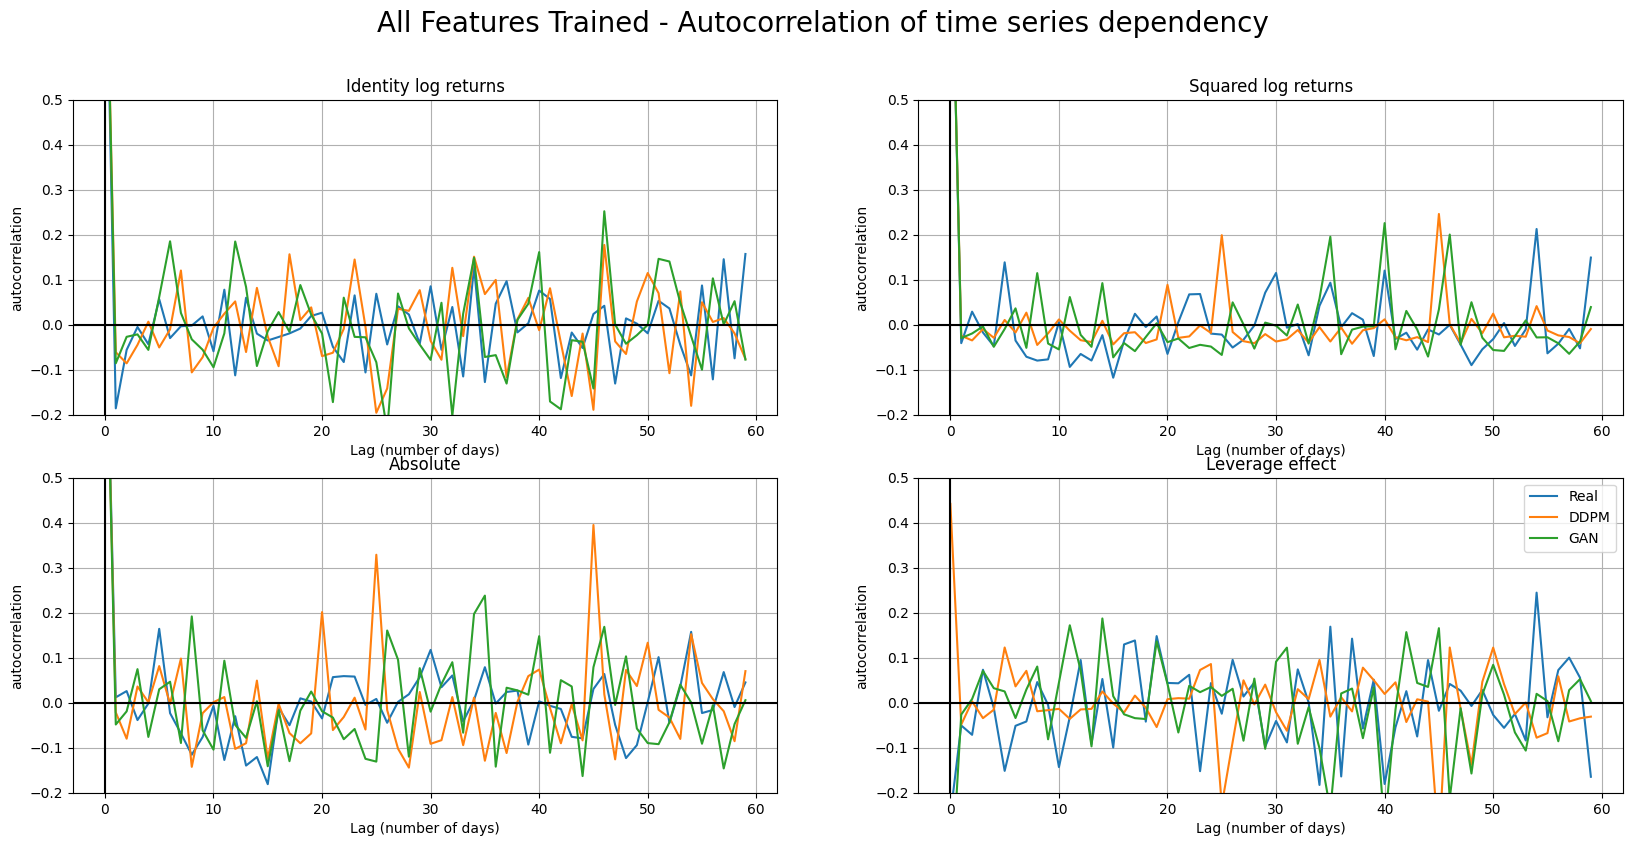

In [370]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 9))

axs[0,0].plot(acf(y_test, 60))
axs[0,0].plot(acf(y_tabddpm, 60))
axs[0,0].plot(acf(synthe_tcn_draw_y, 60))
axs[0,0].set_ylim(-0.2, 0.5)
axs[0,0].set_title('Identity log returns')

axs[0,1].plot(acf(y_test**2, 60))
axs[0,1].plot(acf(y_tabddpm**2, 60))
axs[0,1].plot(acf(synthe_tcn_draw_y**2, 60))
axs[0,1].set_ylim(-0.2, 0.5)
axs[0,1].set_title('Squared log returns')

axs[1,0].plot(acf(abs(y_test), 60, le=False))
axs[1,0].plot(acf(abs(y_tabddpm), 60, le=False))
axs[1,0].plot(acf(abs(synthe_tcn_draw_y), 60, le=False))
axs[1,0].set_ylim(-0.2, 0.5)
axs[1,0].set_title('Absolute')

axs[1,1].plot(acf(y_test, 60, le=True))
axs[1,1].plot(acf(y_tabddpm, 60, le=True))
axs[1,1].plot(acf(synthe_tcn_draw_y, 60, le=True))
axs[1,1].set_ylim(-0.2, 0.5)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days)', ylabel='autocorrelation')
axs[1,1].legend(['Real', 'DDPM', 'GAN'])
fig.suptitle('All Features Trained - Autocorrelation of time series dependency', fontsize=20)